# kNN Grundstruktur

#### Importe

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
from sklearn.model_selection import GridSearchCV
from pathlib import Path

#### Gleichgewichtsdaten importieren

In [2]:
eq_data_file = Path.cwd().parent / 'data' / 'eq_dataset_10000.npz' #Import der GGW Daten
res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output xi
T = np.array(res['T'])
p = np.array(res['p'])
x_0 = np.array(res['x_0'])
xi = np.array(res['xi'])

#print(x_0)

X = np.stack((T, p, x_0[:,0], x_0[:,1], x_0[:,2]), axis = 1)
y = xi
#print(X[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state = 42)

#print(y_train)

#### Normalisierung

In [3]:
# Preprocessing Normalisierung der Daten
mean_in = np.mean(X_train, 0) # Mittelwert
std_in = np.std(X_train, 0) # Standardabweichung
mean_out = y_train.mean()
std_out = np.std(y_train, 0)

X_train = (X_train - mean_in) / std_in
y_train = (y_train - mean_out) / std_out

X_test = (X_test -mean_in) / std_in
y_test = (y_test - mean_out) / std_out

# print(mean_in)
# print(std_in)
# print(X_train)
# print(np.mean(X_train[:,0]))


#### Wahl k, Elbow Curve

13
8


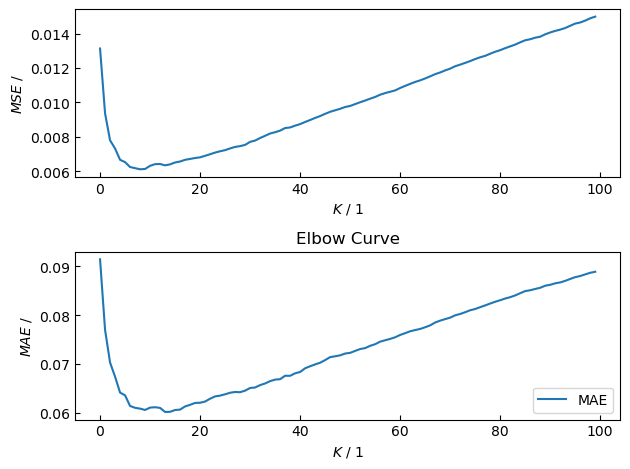

In [4]:
mae_val = []
mse_val = []
#mre_val = []
for K in range(100):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred = model.predict(X_test) #make prediction on test set
    mae = (abs(y_test - pred)).mean()
    mae_val.append(mae)
    mse = MSE(y_test,pred) #calculate mse
    mse_val.append(mse) #store mse values
    #mre = abs((y_test - pred) / y_test).mean() # schlechte Metrik zur Bestimmung von k
    #mre_val.append(mre)
    #print('k = ', K, 'MAE:', mae, 'MSE:', mse)


best_k_mae = mae_val.index(min(mae_val))
print(best_k_mae)

best_k_mse = mse_val.index(min(mse_val)) 
print(best_k_mse)

fig,ax = plt.subplots(2)
#ax[2].plot(mre_val, label='MRE')
ax[0].plot(mse_val, label='MSE')
ax[0].set(xlabel = '$K$ / 1', ylabel = '$MSE$ /') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].plot(mae_val, label='MAE')
ax[1].set(xlabel = '$K$ / 1', ylabel = '$MAE$ /') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
plt.title("Elbow Curve")

plt.legend()
plt.tight_layout()
plt.show()

#### kNN Modell

In [5]:
k = best_k_mae # Anzahl der nächsten Nachbarn
knn_model = KNeighborsRegressor(n_neighbors = k) # Initialisierung
knn_model.fit(X_train, y_train) # Fitten der Trainingsdaten

score_knn_train = knn_model.score(X_train, y_train)
score_knn_test = knn_model.score(X_test, y_test) # Bestimmtheitsmaß R^2 der Vorhersage
print('R^2 Train:', score_knn_train)
print('R^2 Test:', score_knn_test) 

R^2 Train: 0.9949200234483639
R^2 Test: 0.9934719790038942


#### Vorhersage Gleichgewichtsdaten, Error rate

In [6]:
# Vorhersage der Gleichgewichtsdaten
pred_train_norm = knn_model.predict(X_train)
pred_test_norm = knn_model.predict(X_test)

# Denormalisierung
pred_train = pred_train_norm * std_out + mean_out
real_train = y_train * std_out + mean_out
pred_test = pred_test_norm * std_out + mean_out
real_test = y_test * std_out + mean_out

# Performance
performance_train = pd.DataFrame({ 'True Train Value': real_train, 'Train Prediction': pred_train, 'Train Error': real_train - pred_train})
performance_test = pd.DataFrame({'True Test Value': real_test, 'Test Prediction': pred_test, 'Test Error': real_test - pred_test})

print(performance_train)
print(performance_test)

mae_train = (abs(real_train - pred_train)).mean()
mae_test = (abs(real_test - pred_test)).mean()
mre_train = (abs((real_train - pred_train) / real_train)).mean()
mre_test = (abs((real_test - pred_test) / real_test)).mean()
            
print('Train MAE:', mae_train, 'Train MRE:', mre_train, 'Test MAE:', mae_test, 'Test MRE:', mre_test)

      True Train Value  Train Prediction  Train Error
0            -0.025633         -0.029651     0.004018
1            -0.208658         -0.207949    -0.000709
2            -0.137212         -0.140833     0.003622
3            -0.158024         -0.159083     0.001059
4            -0.029343         -0.026412    -0.002931
...                ...               ...          ...
7995         -0.070631         -0.070719     0.000088
7996         -0.135983         -0.146169     0.010186
7997          0.007196          0.011272    -0.004076
7998          0.024824          0.025421    -0.000597
7999         -0.123744         -0.123346    -0.000399

[8000 rows x 3 columns]
      True Test Value  Test Prediction  Test Error
0           -0.069374        -0.073948    0.004575
1           -0.161494        -0.158812   -0.002681
2           -0.293242        -0.280955   -0.012287
3           -0.055850        -0.053557   -0.002294
4           -0.130329        -0.127798   -0.002530
...               ...

#### Parity Plot

Training Dataset: R^2 = 0.9949200234483639
Test Dataset: R^2 = 0.9934719790038942
Max Error Training: |xi - xi_pred| = 0.05036129464685257
Max Error Test: |xi - xi_pred| = 0.04310952626305592


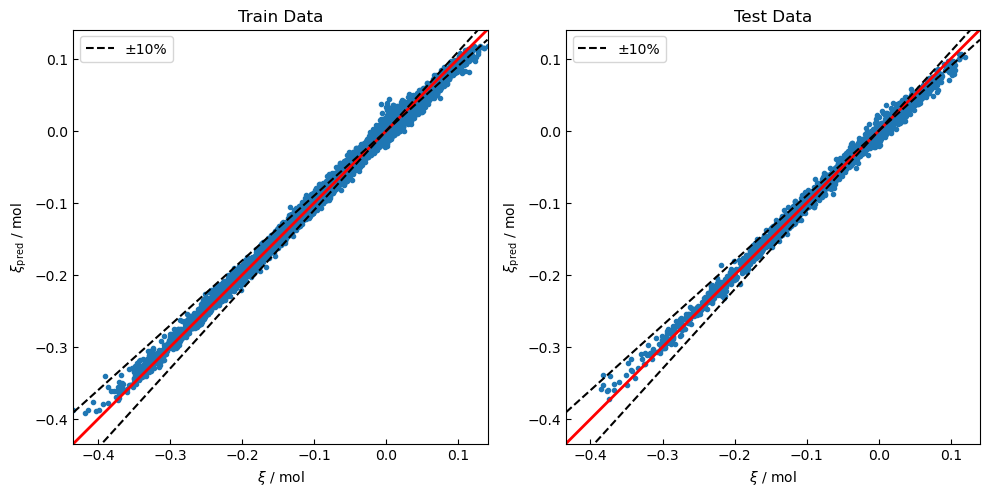

In [7]:
print('Training Dataset: R^2 =', r2(real_train,pred_train))
print('Test Dataset: R^2 =', r2(real_test,pred_test))
print('Max Error Training: |xi - xi_pred| =', max_error(real_train, pred_train))
print('Max Error Test: |xi - xi_pred| =', max_error(real_test, pred_test))

# find the boundaries of X and Y values
bounds = (min(real_train.min(), pred_train.min()) - int(0.1 * pred_train.min()), max(real_train.max(), pred_train.max())+ int(0.1 * pred_train.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(real_train, pred_train, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(real_test, pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Gridsearch CV

In [ ]:
# Liste der zu tunenden Hyperparameter
k = list(range(1,30)) # Anzahl Nachbarn
weights = ['uniform', 'distance']
algorithm = ['auto','ball_tree', 'kd_tree', 'brute'] # Algorithmus zur Berechnung der nächsten Nachbarn
leaf_size = list(range(1,50))
p = [1,2,3] # Metrik zur Bestimmung des Abstands


hyperparameters = dict(n_neighbors = k, weights = weights, algorithm = algorithm, leaf_size = leaf_size, p = p)

# Neues knn Objekt
knn_model_2 = KNeighborsRegressor()

model = GridSearchCV(knn_model_2, hyperparameters, cv = 5)
best_model = model.fit(X_train, y_train)

best_k = best_model.best_estimator_.get_params()['n_neighbors']
best_weights = best_model.best_estimator_.get_params()['weights']
best_algorithm = best_model.best_estimator_.get_params()['algorithm']
best_leaf_size = best_model.best_estimator_.get_params()['leaf_size']
best_p = best_model.best_estimator_.get_params()['p']

print('Best n_neighbors:', best_k)
print('Best weights:', best_weights)
print('Best algorithm:', best_algorithm)
print('Best leaf_size:', best_leaf_size)
print('Best p:', best_p)

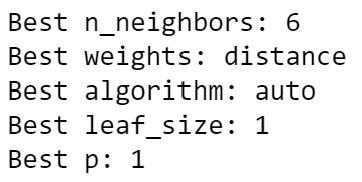

#### Best kNN Model

In [ ]:
knn_model_2 = KNeighborsRegressor(n_neighbors = 6, weights = 'distance', algorithm = 'auto', leaf_size = 1, p = 1) # Initialisierung
#knn_model_2 = KNeighborsRegressor(n_neighbors = best_k, weights = best_weights, algorithm = best_algorithm, leaf_size = best_leaf_size, p = best_p) # Initialisierung
knn_model_2.fit(X_train, y_train) # Fitten der Trainingsdaten

score_knn_train = knn_model_2.score(X_train, y_train)
score_knn_test = knn_model_2.score(X_test, y_test) # Bestimmtheitsmaß R^2 der Vorhersage
print('R^2 Train:', score_knn_train)
print('R^2 Test:', score_knn_test)


In [ ]:
# Vorhersage der Gleichgewichtsdaten
pred_train_norm_2 = knn_model_2.predict(X_train)
pred_test_norm_2 = knn_model_2.predict(X_test)

# Denormalisierung
pred_train_2 = pred_train_norm_2 * std_out + mean_out
real_train_2 = y_train * std_out + mean_out
pred_test_2 = pred_test_norm_2 * std_out + mean_out
real_test_2 = y_test * std_out + mean_out

mae_train_2 = (abs(real_train_2 - pred_train_2)).mean()
mae_test_2 = (abs(real_test_2 - pred_test_2)).mean()
mre_train_2 = (abs((real_train_2 - pred_train_2) / real_train_2)).mean()
mre_test_2 = (abs((real_test_2 - pred_test_2) / real_test_2)).mean()
            
print('Train MAE:', mae_train_2, ' Train MRE:', mre_train_2, ' Test MAE:', mae_test_2, ' Test MRE:', mre_test_2)

In [ ]:
# find the boundaries of X and Y values
bounds = (min(real_train_2.min(), pred_train_2.min()) - int(0.1 * pred_train_2.min()), max(real_train_2.max(), pred_train_2.max())+ int(0.1 * pred_train_2.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(real_train_2, pred_train_2, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(real_test_2, pred_test_2, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", label = ('\xb1' '10%')) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--") # Error line
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()